In [21]:
import os
import torch
import random
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split, Dataset, ConcatDataset
import torch.nn as nn
import torch.optim as optim
from PIL import Image

In [2]:
# Пути к папкам с данными
data_dir = 'data'
normal_dir = os.path.join(data_dir, 'Normal')
covid_dir = os.path.join(data_dir, 'Covid')
viral_pneumonia_dir = os.path.join(data_dir, 'ViralPneumonia')


### В процессе работы встанет вопрос о несбалансированности классов, в папке Normal мы имеем около 10000 изображений, в папке Covid 3600, а в папке ViralPneumonia всего 1400 изображений

In [3]:
# Сбалансируем данные 
def balance_data(folder, target_count):
    files = os.listdir(folder)
    if len(files) > target_count:
        files_to_keep = random.sample(files, target_count)
        for file in files:
            if file not in files_to_keep:
                os.remove(os.path.join(folder, file))

# Приводим все классы к одному количеству (например, 3600, как в Covid)
target_count = 3600
balance_data(normal_dir, target_count)
balance_data(covid_dir, target_count)

# Аугментация данных для класса ViralPneumonia
def augment_data(folder, target_count):
    files = os.listdir(folder)
    current_count = len(files)
    if current_count < target_count:
        # Преобразования для аугментации
        augment_transform = transforms.Compose([
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomRotation(degrees=15),
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
            transforms.RandomResizedCrop(size=(224, 224), scale=(0.8, 1.0)),
        ])
        # Создаем новые изображения
        while current_count < target_count:
            for file in files:
                if current_count >= target_count:
                    break
                img_path = os.path.join(folder, file)
                img = Image.open(img_path)
                augmented_img = augment_transform(img)
                new_file_name = f"augmented_{current_count}.jpg"
                augmented_img.save(os.path.join(folder, new_file_name))
                current_count += 1

# Аугментируем данные для ViralPneumonia
augment_data(viral_pneumonia_dir, target_count)

### Смотрим, что получилось

In [4]:
# Функция для подсчета количества файлов в папке
def count_files(folder):
    return len([name for name in os.listdir(folder) if os.path.isfile(os.path.join(folder, name))])

# Подсчет количества изображений в каждом классе
normal_count = count_files(normal_dir)
covid_count = count_files(covid_dir)
viral_pneumonia_count = count_files(viral_pneumonia_dir)

# Вывод результатов
print(f"Normal: {normal_count} изображений")
print(f"Covid: {covid_count} изображений")
print(f"Viral Pneumonia: {viral_pneumonia_count} изображений")

Normal: 3600 изображений
Covid: 3600 изображений
Viral Pneumonia: 3600 изображений


In [5]:
class XrayDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        """
        Args:
            data_dir: Путь к папке с данными.
            transform: Преобразования, применяемые к изображениям.
        """
        self.root_dir = data_dir
        self.transform = transform
        self.classes = os.listdir(data_dir)  # Список классов (папок)
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.classes)}  # Словарь: класс -> индекс
        self.image_paths = []  # Список путей к изображениям
        self.labels = []  # Список меток

        # Заполняем списки путей и меток
        for cls_name in self.classes:
            cls_dir = os.path.join(data_dir, cls_name)
            for img_name in os.listdir(cls_dir):
                self.image_paths.append(os.path.join(cls_dir, img_name))
                self.labels.append(self.class_to_idx[cls_name])

    def __len__(self):
        """Возвращает количество изображений в наборе данных."""
        return len(self.image_paths)

    def __getitem__(self, idx):
        """
        Возвращает изображение и метку по индексу.
        """
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")  # Открываем изображение и конвертируем в RGB
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)  # Применяем преобразования

        return image, label

### Сделаем сразу трансформации и аугментации для изображений

In [6]:
# Преобразования для изображений
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Изменение размера изображений
    transforms.RandomHorizontalFlip(),  # Случайное отражение по горизонтали
    transforms.RandomRotation(10),      # Случайный поворот на ±10 градусов
    transforms.ToTensor(),          # Преобразование в тензор
    transforms.Normalize(           # Нормализация
        mean=[0.485, 0.456, 0.406], # Средние значения для ImageNet
        std=[0.229, 0.224, 0.225]   # Стандартные отклонения для ImageNet
    )
])

# Загрузка данных
dataset = XrayDataset(data_dir, transform=transform)

In [7]:
# Разделение данных
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


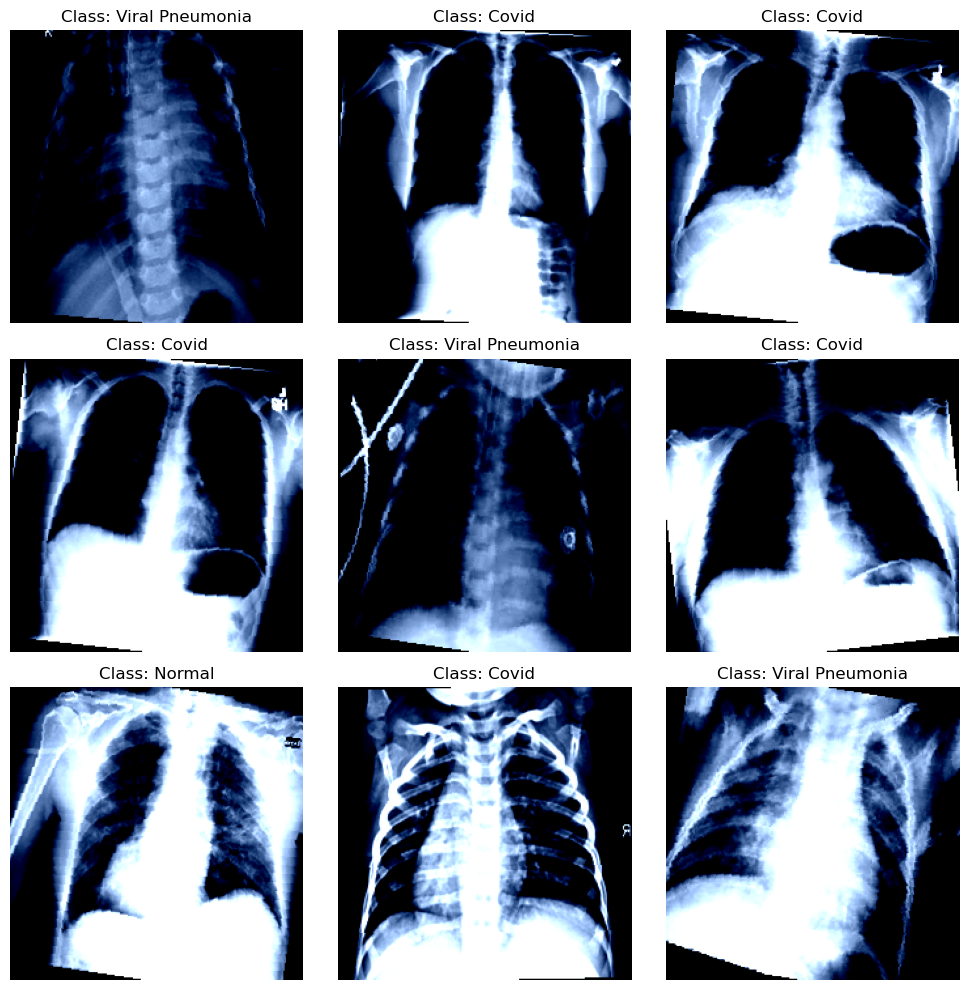

In [8]:
import matplotlib.pyplot as plt
import random

# Функция для визуализации изображений
def visualize_random_images(dataset, class_names, num_images=9):
    # Выбираем случайные индексы
    indices = random.sample(range(len(dataset)), num_images)
    
    # Создаем сетку для отображения изображений
    plt.figure(figsize=(10, 10))
    for i, idx in enumerate(indices):
        image, label = dataset[idx]  # Получаем изображение и метку
        image = image.permute(1, 2, 0)  # Меняем размерности для отображения (C, H, W) -> (H, W, C)
        
        # Отображаем изображение
        plt.subplot(3, 3, i + 1)
        plt.imshow(image)
        plt.title(f"Class: {class_names[label]}")
        plt.axis("off")
    
    plt.tight_layout()
    plt.show()

# Названия классов (соответствуют порядку в dataset.classes)
class_names = ["Normal", "Covid", "Viral Pneumonia"]

# Визуализируем случайные изображения из тренировочной выборки
visualize_random_images(train_dataset, class_names, num_images=9)

### посмотрим на полученный датасет 

In [9]:
dataset[56] # данные нормализованы

(tensor([[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          ...,
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],
 
         [[-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          ...,
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357]],
 
         [[-1.8044, -1.8044, -1.8044,  ..., -1.8044, -1.8044, -1.8044],
          [-1.8044, -1.8044,

In [10]:
dataset #применились преобразования, аугментации и переведено всё в тензор

Тренировочная выборка:
Normal: 2912 изображений
Covid: 2859 изображений
Viral Pneumonia: 2869 изображений

Валидационная выборка:
Normal: 347 изображений
Covid: 374 изображений
Viral Pneumonia: 359 изображений

Тестовая выборка:
Normal: 341 изображений
Covid: 367 изображений
Viral Pneumonia: 372 изображений


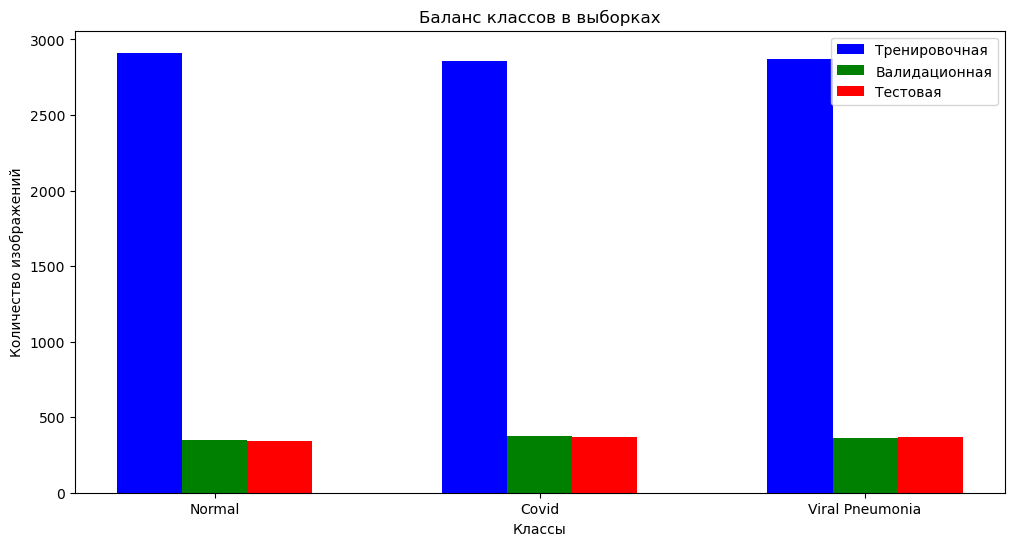

In [11]:
# Функция для подсчета количества изображений каждого класса в выборке
def count_class_distribution(dataset, original_dataset, class_names):
    # Создаем словарь для подсчета
    class_counts = {class_name: 0 for class_name in class_names}
    
    # Проходим по всем элементам выборки
    for idx in dataset.indices:
        _, label = original_dataset[idx]  # Получаем метку класса
        class_name = class_names[label]   # Получаем имя класса
        class_counts[class_name] += 1     # Увеличиваем счетчик
    
    return class_counts

# Подсчет распределения классов для каждой выборки
train_class_counts = count_class_distribution(train_dataset, dataset, class_names)
val_class_counts = count_class_distribution(val_dataset, dataset, class_names)
test_class_counts = count_class_distribution(test_dataset, dataset, class_names)

# Вывод распределения классов
print("Тренировочная выборка:")
for class_name, count in train_class_counts.items():
    print(f"{class_name}: {count} изображений")

print("\nВалидационная выборка:")
for class_name, count in val_class_counts.items():
    print(f"{class_name}: {count} изображений")

print("\nТестовая выборка:")
for class_name, count in test_class_counts.items():
    print(f"{class_name}: {count} изображений")

# Визуализация баланса классов
def plot_class_distribution(train_counts, val_counts, test_counts, class_names):
    x = np.arange(len(class_names))  # Позиции для классов
    width = 0.2  # Ширина столбцов

    plt.figure(figsize=(12, 6))

    # Столбцы для тренировочной, валидационной и тестовой выборок
    plt.bar(x - width, train_counts.values(), width, label="Тренировочная", color="blue")
    plt.bar(x, val_counts.values(), width, label="Валидационная", color="green")
    plt.bar(x + width, test_counts.values(), width, label="Тестовая", color="red")

    # Настройки графика
    plt.title("Баланс классов в выборках")
    plt.xlabel("Классы")
    plt.ylabel("Количество изображений")
    plt.xticks(x, class_names)  # Подписи классов на оси X
    plt.legend()
    plt.show()

# Визуализируем баланс классов
plot_class_distribution(train_class_counts, val_class_counts, test_class_counts, class_names)

In [12]:
# Получаем метки классов из датасета
labels = [label for _, label in dataset]

# Считаем количество изображений для каждого класса
class_counts = Counter(labels)

# Выводим результат
for class_idx, count in class_counts.items():
    print(f"Class: {class_names[class_idx]}, Count: {count}")

Class: Normal, Count: 3600
Class: Covid, Count: 3600
Class: Viral Pneumonia, Count: 3600


### Данные сбалансированы, преобразованы и аугментированы, можем начать процесс 

# DataLoader

In [13]:
# Создание DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Проверка размеров выборок
print(f"Тренировочная выборка: {len(train_dataset)} изображений")
print(f"Валидационная выборка: {len(val_dataset)} изображений")
print(f"Тестовая выборка: {len(test_dataset)} изображений")

Тренировочная выборка: 8640 изображений
Валидационная выборка: 1080 изображений
Тестовая выборка: 1080 изображений


In [26]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models


# Загружаем предобученную ResNet18
model = models.resnet18(pretrained=True)

# Заменяем последний слой для нашего числа классов (например, 3 класса)
num_classes = 3  # Normal, Covid, Viral Pneumonia
model.fc = nn.Linear(model.fc.in_features, num_classes)


In [28]:
# Переносим модель на устройство (GPU, если доступно)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [29]:
# Функция потерь (для классификации)
criterion = nn.CrossEntropyLoss()

# Оптимизатор (можно использовать Adam или SGD)
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [34]:
# Количество эпох
EPOCHS = 15

# Для хранения метрик
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []
best_test_accuracy = 0.0  # Для хранения лучшей точности на валидации

# Цикл обучения
for epoch in range(EPOCHS):
    # Обучение
    model.train()
    train_loss = 0.0
    train_acc = 0.0

    for batch_idx, (inputs, labels) in enumerate(train_loader):
        # Переносим данные на устройство
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Прямое распространение
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        train_loss += loss.item()

        # Обратное распространение и обновление весов
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Вычисляем точность
        _, predicted = torch.max(outputs, 1)
        train_acc += (predicted == labels).sum().item() / len(outputs)

    # Средние значения потерь и точности для тренировочной выборки
    train_loss = train_loss / len(train_loader)
    train_acc = train_acc / len(train_loader)
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # Валидация
    model.eval()
    test_loss = 0.0
    test_acc = 0.0

    with torch.no_grad():  # Отключаем вычисление градиентов
        for batch_idx, (inputs, labels) in enumerate(test_loader):
            # Переносим данные на устройство
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Прямое распространение
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()

            # Вычисляем точность
            _, predicted = torch.max(outputs, 1)
            test_acc += (predicted == labels).sum().item() / len(outputs)

    # Средние значения потерь и точности для валидационной выборки
    test_loss = test_loss / len(test_loader)
    test_acc = test_acc / len(test_loader)
    test_losses.append(test_loss)
    test_accuracies.append(test_acc)

    # Вывод метрик
    print(f'Epoch [{epoch + 1}/{EPOCHS}], '
          f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2%}, '
          f'Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2%}')

    # Сохраняем лучшую модель
    if test_acc > best_test_accuracy:
        best_test_accuracy = test_acc
        torch.save(model.state_dict(), 'best_model.pth')
        print(f"Лучшая модель сохранена с точностью {best_test_accuracy:.2%}")

# После обучения
print("Обучение завершено!")
print(f"Лучшая точность на валидации: {best_test_accuracy:.2%}")

Epoch [1/15], Train Loss: 0.1836, Train Acc: 93.28%, Test Loss: 0.2178, Test Acc: 91.18%
Лучшая модель сохранена с точностью 91.18%
Epoch [2/15], Train Loss: 0.1398, Train Acc: 94.81%, Test Loss: 0.1418, Test Acc: 94.58%
Лучшая модель сохранена с точностью 94.58%
Epoch [3/15], Train Loss: 0.1258, Train Acc: 95.46%, Test Loss: 0.2454, Test Acc: 90.96%
Epoch [4/15], Train Loss: 0.1148, Train Acc: 95.96%, Test Loss: 0.1888, Test Acc: 93.38%
Epoch [5/15], Train Loss: 0.0924, Train Acc: 96.88%, Test Loss: 0.1159, Test Acc: 95.86%
Лучшая модель сохранена с точностью 95.86%
Epoch [6/15], Train Loss: 0.1030, Train Acc: 96.33%, Test Loss: 0.1063, Test Acc: 96.23%
Лучшая модель сохранена с точностью 96.23%
Epoch [7/15], Train Loss: 0.1000, Train Acc: 96.52%, Test Loss: 0.0992, Test Acc: 96.20%
Epoch [8/15], Train Loss: 0.0697, Train Acc: 97.71%, Test Loss: 0.1120, Test Acc: 95.96%
Epoch [9/15], Train Loss: 0.0776, Train Acc: 97.14%, Test Loss: 0.1513, Test Acc: 94.30%
Epoch [10/15], Train Loss: 

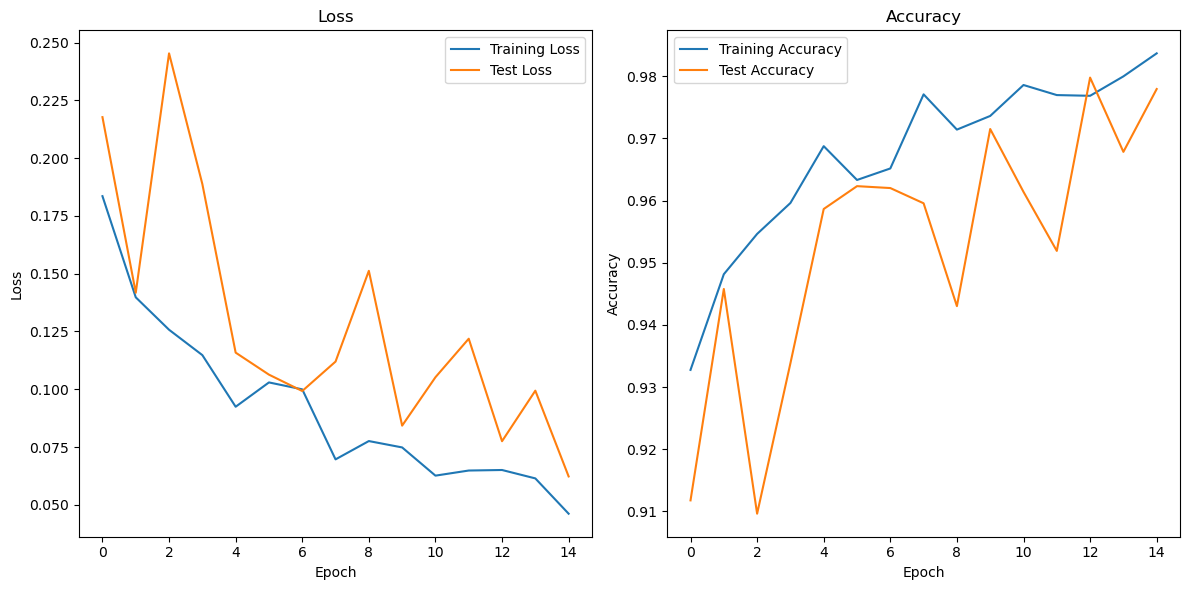

In [36]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss')

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy')

plt.tight_layout()
plt.show()

In [35]:

from sklearn.metrics import classification_report, confusion_matrix

# Переводим модель в режим оценки
model.eval()

# Для хранения предсказаний и истинных меток
predictions = []
true_labels = []

# Отключаем вычисление градиентов
with torch.no_grad():
    for batch_idx, (inputs, labels) in enumerate(val_loader):
        # Переносим данные на устройство
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Прямое распространение
        outputs = model(inputs)

        # Получаем предсказанные классы
        predicted_class = torch.argmax(torch.softmax(outputs, dim=1), dim=1)

        # Сохраняем предсказания и истинные метки
        predictions.extend(predicted_class.cpu().numpy())  # Переносим на CPU и преобразуем в numpy
        true_labels.extend(labels.cpu().numpy())  # Переносим на CPU и преобразуем в numpy

# Преобразуем списки в numpy массивы
predictions = np.array(predictions)
true_labels = np.array(true_labels)

# Выводим отчет о классификации
print("Classification Report:")
print(classification_report(true_labels, predictions, target_names=["Normal", "Covid", "Viral Pneumonia"]))

# Выводим матрицу ошибок
print("Confusion Matrix:")
print(confusion_matrix(true_labels, predictions))

Classification Report:
                 precision    recall  f1-score   support

         Normal       0.99      0.95      0.97       347
          Covid       0.94      0.99      0.96       374
Viral Pneumonia       0.99      0.98      0.99       359

       accuracy                           0.97      1080
      macro avg       0.97      0.97      0.97      1080
   weighted avg       0.97      0.97      0.97      1080

Confusion Matrix:
[[328  18   1]
 [  4 369   1]
 [  0   6 353]]


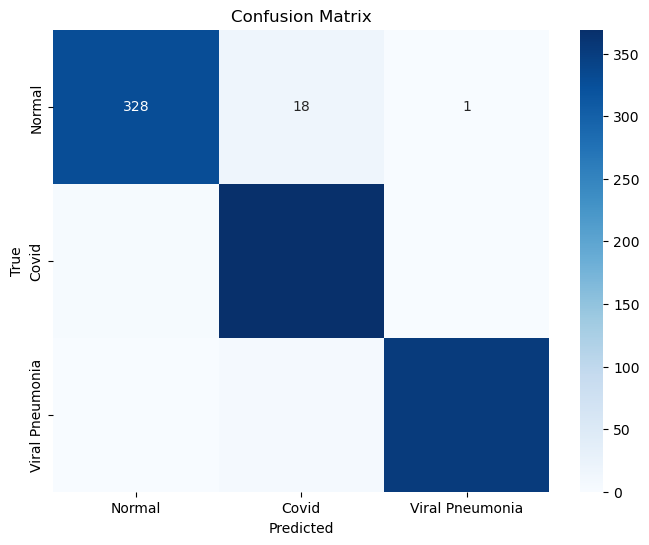

In [37]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(true_labels, predictions), annot=True, fmt="d", cmap="Blues",
            xticklabels=["Normal", "Covid", "Viral Pneumonia"],
            yticklabels=["Normal", "Covid", "Viral Pneumonia"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()